<a href="https://colab.research.google.com/github/elizabethts/DS5-kaggle-scalar-coupling/blob/master/notebooks/Chance_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install kaggle
# !mkdir .kaggle

import json
token = ''
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json


!kaggle competitions download -c champs-scalar-coupling

In [0]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
# !pip install category_encoders
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

In [0]:
# !unzip /content/{/content}/competitions/champs-scalar-coupling/dipole_moments.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/structures.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/scalar_coupling_contributions.csv.zip

In [0]:
trainval = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/train.csv.zip')
test = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/test.csv.zip')
structures = pd.read_csv('/content/structures.csv')
dipole = pd.read_csv('/content/dipole_moments.csv')
contrib = pd.read_csv('/content/scalar_coupling_contributions.csv')

In [0]:
def merge_train_structures(train, structures):
  
  """This function is used to merge the structures dataset to the 
     original train dataset
     
     Parameters:
     ===========
	   train: train dataframe
	   structures: structures dataframe.
     
     Output:
	   ===========
	   dataframe: merged dataframe
     """
  
  structures = structures.rename({'atom_index': 'atom_index_0',
                                  'x':'x_0', 'y':'y_0', 'z':'z_0',
                                  'atom':'atom_0'}, axis=1)
  
  merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])
  
  structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)
  
  merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])
  
  structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
  
  assert train.shape[0] == merged.shape[0]
  
  return merged_1

In [0]:
merged = merge_train_structures(trainval, structures)

In [0]:
def fe(df):
#   df['dihedral_angle'] = abs(df['x_0'] * df['x_1'] + df['y_0'] * df['y_1'] + df['z_0'] * df['z_1']) / (np.sqrt(np.square(df['x_0']) + np.square(df['y_0']) + np.square(df['z_0'])) * (np.sqrt(np.square(df['x_1']) + np.square(df['y_1']) + np.square(df['z_1']))))
  df['bond'] = df['type'].str[2:]
  df['j_type'] = df['type'].str[:2]
  df['distance'] = np.power((np.power((df['x_1'] - df['x_0']), 2) + np.power((df['y_1'] - df['y_0']), 2) + np.power((df['z_1'] - df['z_0']), 2)), 0.5)
  df = pd.merge(df, contrib, on=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [0]:
fe(merged)


In [0]:
merged = pd.merge(merged, contrib, on=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [43]:
train, val = train_test_split(merged, random_state=47)
train.shape[0] + val.shape[0] == trainval.shape[0]

True

In [0]:
groups = val['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
  maes = (y_true - y_pred).abs().groupby(groups).mean()
  return np.log(maes.map(lambda x: max(x, floor))).mean()

In [52]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,bond,j_type,distance,fc,sd,pso,dso
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,HC,1J,1.091953,83.0224,0.254579,1.25862,0.272010
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,HC,1J,1.091952,83.0222,0.254585,1.25861,0.272013
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,HC,1J,1.091946,83.0241,0.254634,1.25856,0.272012
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,HC,1J,1.091948,83.0243,0.254628,1.25856,0.272012
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,HH,2J,1.783120,-11.0347,0.352978,2.85839,-3.433600


In [53]:
%%time
features = ['type', 'atom_1', 'bond', 'j_type', 'distance', 'dso', 'pso']
target = 'scalar_coupling_constant'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

y_train_log = np.log1p(y_train)

xgbr = XGBRegressor(n_estimators=100,
                    random_state=47,
                    n_jobs=-1)

encoder = OrdinalEncoder()

pipe = make_pipeline(encoder, xgbr)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log1p
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[03:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6min 18s, sys: 484 ms, total: 6min 19s
Wall time: 3min 37s


In [54]:
group_lmae(y_val, y_pred, groups)

0.717692519740361

In [55]:
importances = xgbr.feature_importances_.astype(float)
features = X_train.columns
importances

array([5.80838230e-03, 1.38996096e-04, 0.00000000e+00, 9.81952608e-01,
       3.97996511e-03, 5.53997932e-03, 2.58003827e-03])

In [56]:
print(features.shape)
print(importances.shape)

(7,)
(7,)


<BarContainer object of 7 artists>

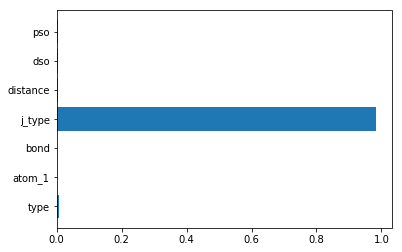

In [57]:
plt.barh(features, importances)

In [0]:
test_merged = merge_train_structures(test, structures)

In [0]:
fe(test_merged)

In [0]:
test = pd.merge(test, contrib, on=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [0]:
y_pred = pipe.predict(test_merged[features])

In [0]:
sub = pd.DataFrame(data = {
    'id': test_merged['id'],
    'scalar_coupling_constant': y_pred 
})
sub.to_csv('submissionscalar.csv', index=False)

In [0]:
files.download('submissionscalar.csv')

In [0]:
merged = pd.merge(merged, contrib, on=['molecule_name', 'atom_index_0', 'atom_index_1'])

In [25]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,bond,j_type,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,HC,1J,1.091953
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,HC,1J,1.091952
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,HC,1J,1.091946
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,HC,1J,1.091948
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,HH,2J,1.783120


In [21]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,bond,j_type,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,HC,1J,1.091953
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,HC,1J,1.091952
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,HC,1J,1.091946
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,HC,1J,1.091948
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,HH,2J,1.783120
